In [ ]:
'''
1. RUN THE CELLS SEQUENTIALLY TO AVOID ANY IMPEDIMENTS
2. READ THE INSTRUCTIONS IN EACH CELL CAREFULLY
3. IN THE ABSENCE OF ANY INSTRUCTIONS, YOU MAY PROCEED TO RUN IT

This plot comprises the scatter plot for the β and α values corresponding to paradigm-I (5 classes)
'''

In [15]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
from scipy import stats
import numpy as np
import shutil
import pickle
import random

plt.style.use(["science", "no-latex"])
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


In [16]:
def load_res(save_loc, dest_folder=None):
    if dest_folder is not None:
        os.makedirs(dest_folder, exist_ok=True)
        shutil.copy("results/{}".format(save_loc), dest_folder)

    with open("results/{}".format(save_loc), "rb") as f:
        res = pickle.load(f)

    return res


def avg_across_dicts(dicts):
    """

    Args:
        dicts: list of dictionaries with same keys and lists as elements

    Returns:
        single dict with the keys and average of lists

    """
    avg_dict = dict()
    keys = dicts[0].keys()
    for k in keys:
        values = []
        for d in dicts:
            values.append(d[k])
        avg_dict[k] = np.mean(values, axis=0)

    return avg_dict


def str_contains(word_list, string):
    for word in word_list:
        if word not in string:
            return False

    return True

def sort_first_five_characters(string):
    sorted_chars = ''.join(sorted(string[:5]))
    sorted_string = sorted_chars + string[5:]
    return sorted_string

def remove_duplicate_keys(dictionary):
    dictionary = {sort_first_five_characters(k): v for k, v in dictionary.items()}
    unique_keys = set(dictionary.keys())
    new_dictionary = {key: dictionary[key] for key in unique_keys}
    return new_dictionary

In [53]:
# 1. This section is for the F-score bar plots for 5 classes and 10 classes ~ stream learning
# 2. Select algorithm type; 'naive' here corresponds to 'vanilla' in the ICCV paper
# 3. Select dtype (_5 for paradigm-I and _10 for paradigm-II)
_alg_type = "naive" # naive / ewc / lwf
dtype = "cifar_5" # mnist_5 / fmnist_5 / cifar_5 / mnist_10 / fmnist_10 / cifar_10

indicators, t1_indicators = None, None

if dtype == "fmnist_5":
    indicators = ["mnist.FashionMNIST", "classes.5", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.5", "-t1"]
elif dtype == "fmnist_10":
    indicators = ["mnist.FashionMNIST", "classes.10", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.10", "-t1"]
elif dtype == "mnist_5":
    indicators = ["mnist.MNIST", "classes.5", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.5", "-t1"]
elif dtype == "mnist_10":
    indicators = ["mnist.MNIST", "classes.10", "-avg"]
    t1_indicators = ["mnist.FashionMNIST", "classes.10", "-t1"]
elif dtype == "cifar_5":
    indicators = ["cifar.CIFAR10", "classes.5", "-avg"]
    t1_indicators = ["cifar.CIFAR10", "classes.5", "-t1"]
elif dtype == "cifar_10":
    indicators = ["cifar.CIFAR10", "classes.10", "-avg"]
    t1_indicators = ["cifar.CIFAR10", "classes.10", "-t1"]
elif dtype == "NovelNet":
    indicators = ["NovelNet", "-avg"]
    t1_indicators = ["NovelNet", "-t1"]

In [54]:
files = os.listdir("results")
result_dicts = [
    load_res(f)
    for f in files
    if f[-3:] == "pkl" and str_contains(indicators + [_alg_type], f) and not str_contains(['epochs.3'], f)
]
t1_dicts = [
    load_res(f)
    for f in files
    if f[-3:] == "pkl" and str_contains(t1_indicators + [_alg_type], f) and not str_contains(['epochs.3'], f)
]
result_dict, t1_dict = avg_across_dicts(result_dicts), avg_across_dicts(t1_dicts)

T-Statistic: 25.294089992116206
P-value: 1.615668211794183e-15
top mean: 0.40331381588084464, top std: 0.00568420874338027
bottom mean: 0.3299116572371386, bottom std: 0.006594053524647546


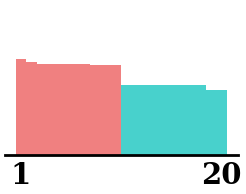

In [5]:
mpl.rcParams['axes.linewidth'] = 2

mpl.rcParams['axes.spines.left'] = False
plt.figure(dpi=100, figsize=(3, 2))
f_var = {
    k: (2 * v[-1]) / ((v_t1[0] - v_t1[-1]) * v[-1] + 1)
    for v, v_t1, k in zip(result_dict.values(), t1_dict.values(), result_dict.keys())
}
if dtype == 'NovelNet':
    f_var = remove_duplicate_keys(f_var)
f_var = dict(sorted(f_var.items(), key=lambda item: item[1], reverse=True))

x_red, x_blue, y_red, y_blue = [], [], [], []
cnt = 1
for idx, (key, f_val) in enumerate(zip(f_var.keys(), f_var.values())):
    if idx < 10:
        x_red.append(cnt), y_red.append(f_val)
        cnt += 1
    elif idx >= 110:
        x_blue.append(cnt), y_blue.append(f_val)
        cnt += 1

plt.bar(x_blue, y_blue, color="mediumturquoise", label="worst curricula", width=1)
plt.bar(x_red, y_red, color="lightcoral", label="best curricula", width=1)
# plt.xlabel("curricula", fontdict={'weight': 'bold', 'size': 21, 'fontname': 'TImes New Roman'})
# plt.ylabel("F", fontdict={'weight': 'bold', 'size': 21, 'fontname': 'TImes New Roman'})
# plt.legend(loc="upper right", fontsize=10)
plt.tick_params(axis="x", which="both", bottom=False, top=False)
plt.tick_params(axis="y", which="both", left=False, right=False)
plt.ylim(0.1, 0.6)
plt.yticks([], weight='bold', size=21)
plt.xticks([1, 20], weight='bold', size=21)

# Perform t-test
t_statistic, p_value = stats.ttest_ind(y_red, y_blue)

# Print the results
print("T-Statistic:", t_statistic)
print("P-value:", p_value)
print("top mean: {}, top std: {}".format(np.mean(y_red), np.std(y_red)))
print("bottom mean: {}, bottom std: {}".format(np.mean(y_blue), np.std(y_blue)))
# plt.text(0.5, 0.62, "p-value: {}".format(f"{p_value:.2e}"), fontsize=11, color='black')
# plt.savefig('paper.fig.fscores.bar__1010.{}.{}.png'.format(dtype, _alg_type), dpi=200)